## **Proyecto INFO279**
###### **Gerson Andrade Meza**

In [232]:
##############################
# Importación de librerías   #
##############################

import pandas as pd
import spacy
import numpy as np
from spacy.matcher import Matcher


nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline


from pprint import pprint
import geopandas as gpd
from pandasql import sqldf
from IPython.display import clear_output
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import statistics as stats
import random

#Sentiment analysis
from tqdm import tqdm # Barra de progreso


import transformers
transformers.__version__
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
clear_output(wait=True)

In [233]:
comunas= ["Puerto Montt", "Calbuco", "Cochamó", "Fresia", "Frutillar", "Los Muermos", "Llanquihue", "Maullín", "Puerto Varas", "Castro", "Ancud", "Chonchi", "Curaco de Vélez", "Dalcahue", "Puqueldón", "Queilén", "Quellón", "Quemchi", "Quinchao", "Osorno", "Puerto Octay", "Purranque", "Puyehue", "Río Negro", "San Juan de la Costa", "San Pablo", "Chaitén", "Futaleufú", "Hualaihué", "Palena"]


### ***Parte 1: Import de datos***

Los datos fueron extraidos desde el motor de búsqueda de sophia2, desde el **1 de Enero del 2020** al **1 de febrero del 2020**

In [234]:
archivo = "./data/DataFrame_Comunas.csv"
corpus = pd.read_csv(archivo, encoding='utf-8')
corpus.head(1)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date,Ancud,Calbuco,...,Puqueldón,Purranque,Puyehue,Queilén,Quellón,Quemchi,Quinchao,Río Negro,San Juan de la Costa,San Pablo
0,0,21892281.0,chile,radiosago,https://www.radiosago.cl/91469-2/,Cámara de Comercio de Puerto Montt cuestionó c...,"El gremio criticó que las bases de Sercotec, a...",2020-01-31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ***Parte 2: Extraemos los tópicos con LDA***


In [235]:
#Extraemos las noticias
noticias = corpus.text.values.tolist()

In [236]:
##Preprocesamiento
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

In [237]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [238]:
len(noticias)

2185

In [239]:
noticias_procesadas = []
print("procesando")
for index, noticia in enumerate(noticias):
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

    clear_output(wait=True)
print("Noticias procesadas correctamente")

Noticias procesadas correctamente


In [240]:
#Procesamiento con LDA

id2word = corpora.Dictionary(noticias_procesadas)


***Buscamos el número óptimo de tópicos**

In [241]:
texts = noticias_procesadas
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

In [242]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [243]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=2, limit=15, step=2)

2
4
6
8
10
12
14


In [244]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [245]:
# Guardamos el modelo optimo

lda_model.save('./data/modelo//LDA_Modelo')

**Mostramos los topicos**

In [246]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)

vis

C:\Users\Gerso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.170338 -0.066103       1        1  40.445998
2     -0.066085  0.103525       2        1  26.823018
0      0.118192 -0.156092       3        1  19.172161
1      0.118231  0.118670       4        1  13.558823, topic_info=             Term        Freq       Total Category  logprob  loglift
372      proyecto  593.000000  593.000000  Default  30.0000  30.0000
77       incendio  261.000000  261.000000  Default  29.0000  29.0000
364      millones  443.000000  443.000000  Default  28.0000  28.0000
1110  estudiantes  296.000000  296.000000  Default  27.0000  27.0000
1759       prueba  326.000000  326.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
36          horas   78.147175  705.607272   Topic4  -5.9563  -0.2023
143       domingo   63.820726  288.399655   Topic4  -6.1588   0.4899
1347          fin   61.984006  328.885204   Topic4  -6.1880   0.3293
1040       sábado   60.367801  263.265007   Topic4  -6.2144   0.5254
27         ciudad   61.751742  473.261231   Topic4  -6.1917  -0.0384

[287 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
9623       4  0.962435                K
33639      4  0.991072  VerdadesOcultas
381        3  0.987189          abogado
206        3  0.995218        accidente
292        1  0.193640        actividad
...      ...       ...              ...
850        1  0.993265            votos
257        3  0.991324          víctima
3588       1  0.950642            zonas
3588       2  0.047532            zonas
13785      3  0.994417                {

[433 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

### ***Parte 3: Temas dominantes***


In [247]:
def format_topics_documents(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=lda_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


C:\Users\Gerso\AppData\Local\Temp\ipykernel_42228\2222007393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Gerso\AppData\Local\Temp\ipykernel_42228\2222007393.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


In [248]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3,0.9234,"proyecto, personas, año, parte, millones, país...","El gremio criticó que las bases de Sercotec, a..."
1,1,0,0.8294,"sector, lugar, años, incendio, personas, inves...",El corazón del sector céntrico de la ciudad de...
2,2,0,0.9639,"sector, lugar, años, incendio, personas, inves...",La joven madre de 22 años fue formalizada en e...
3,3,3,0.5603,"proyecto, personas, año, parte, millones, país...",Tras la violenta jornada registrada en la capi...
4,4,0,0.9861,"sector, lugar, años, incendio, personas, inves...",El ministerio Público solicitó al Juzgado de G...


In [249]:
corpus.head(1)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date,Ancud,Calbuco,...,Puqueldón,Purranque,Puyehue,Queilén,Quellón,Quemchi,Quinchao,Río Negro,San Juan de la Costa,San Pablo
0,0,21892281.0,chile,radiosago,https://www.radiosago.cl/91469-2/,Cámara de Comercio de Puerto Montt cuestionó c...,"El gremio criticó que las bases de Sercotec, a...",2020-01-31,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [250]:
#Le hacemos un join para tener el df junto con todo
df_dominant_topic= df_dominant_topic.join(corpus)  

In [251]:
df_dominant_topic.head(1)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Unnamed: 0,id_news,country,media_outlet,url,...,Puqueldón,Purranque,Puyehue,Queilén,Quellón,Quemchi,Quinchao,Río Negro,San Juan de la Costa,San Pablo
0,0,3,0.9234,"proyecto, personas, año, parte, millones, país...","El gremio criticó que las bases de Sercotec, a...",0,21892281.0,chile,radiosago,https://www.radiosago.cl/91469-2/,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ***Parte 4: Ahora analizamos la positividad de las noticias con Sentiment Analysis***

In [252]:
# --- Cargamos el modelo ---
model_name = "finiteautomata/beto-sentiment-analysis"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [253]:
df_dominant_topic['title_label'] = ""
df_dominant_topic['title_score'] = ""

for index, row in tqdm(df_dominant_topic.iterrows(), desc='Análisis de sentimiento', total=df_dominant_topic.shape[0]):
    
    # Analizamos su sentimiento en inglés
    sentiment_value = nlp(row['title'])
    
    # Insertamos en dataframe
    df_dominant_topic.at[index, "title_label"] = sentiment_value[0].get('label')
    df_dominant_topic.at[index, "title_score"] = sentiment_value[0].get('score')

Análisis de sentimiento: 100%|██████████| 2185/2185 [01:42<00:00, 21.30it/s]


In [254]:
#En algún momento se me coló una columna text, asi que la borro para no tener duplicados
df_dominant_topic = df_dominant_topic.drop(['text'], axis=1)

clear_output(wait=True)

In [255]:
df_dominant_topic.head(3)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Unnamed: 0,id_news,country,media_outlet,url,...,Puyehue,Queilén,Quellón,Quemchi,Quinchao,Río Negro,San Juan de la Costa,San Pablo,title_label,title_score
0,0,3,0.9234,"proyecto, personas, año, parte, millones, país...","El gremio criticó que las bases de Sercotec, a...",0,21892281.0,chile,radiosago,https://www.radiosago.cl/91469-2/,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEG,0.967949
1,1,0,0.8294,"sector, lugar, años, incendio, personas, inves...",El corazón del sector céntrico de la ciudad de...,1,21892289.0,chile,radiosago,https://www.radiosago.cl/video-puerto-montt-lo...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEG,0.999126
2,2,0,0.9639,"sector, lugar, años, incendio, personas, inves...",La joven madre de 22 años fue formalizada en e...,2,21892293.0,chile,radiosago,https://www.radiosago.cl/solicitaron-pericia-p...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NEG,0.95262


In [256]:
#Se guarda el dataframe + su analisis de sentimiento
df_dominant_topic.to_csv('./data/DataFrame_Sentiment_Analysis.csv', index=False)
print("Guardado correctamente")


# positivo = sqldf("SELECT * FROM df_dominant_topic WHERE title_label='POS'")

# for i,row in positivo.iterrows():
#     print(row['title'])

Guardado correctamente


### ***Parte 5: Graficamos los mapas***

In [257]:
#De shape sacamos el territorio y su geometría
territory = gpd.read_file(r'./shape/comunas.shp', encoding='utf-8')
territory.head(1)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
0,48,170038.624165,16,8,6204,6,9.685774e+08,206184.271675,Región del Libertador Bernardo O'Higgins,Marchigüe,Cardenal Caro,"POLYGON ((-7992818.789 -4056669.319, -7992731...."


In [258]:
#Usamos solo los de la 10 region
territory = territory[territory["codregion"] == 10]
territory.head(1)

,objectid,shape_leng,dis_elec,cir_sena,cod_comuna,codregion,st_area_sh,st_length_,Region,Comuna,Provincia,geometry
29,133,182841.388347,25,13,10307,10,1.087024e+09,240044.217066,Región de Los Lagos,San Pablo,Osorno,"POLYGON ((-8174316.930 -4910454.843, -8174109...."


In [259]:
#solo dejamos la comuna y su geometria
territory = territory[["Comuna", "geometry"]]
territory.head(3)

,Comuna,geometry
29,San Pablo,"POLYGON ((-8174316.930 -4910454.843, -8174109...."
50,Puqueldón,"POLYGON ((-8192405.306 -5246776.357, -8192341...."
51,Fresia,"MULTIPOLYGON (((-8226493.287 -5038106.271, -82..."


In [260]:
comunas.sort()

**Relevancia de cada comuna en los medios de prensa en base a la cantidad de noticias donde se nombra**

In [261]:
petitionSQLDF  = 'SELECT '
for comuna in comunas :
    # Si encuentra un espacio entonces añade corchetes para la petición en mysql
    if comuna.find(' ') > 0 :
        petitionSQLDF = petitionSQLDF+('sum(['+comuna+']), ')
    else :
        petitionSQLDF = petitionSQLDF+('sum('+comuna+'), ')

petitionSQLDF = petitionSQLDF[:-2] # eliminamos la última coma
petitionSQLDF = petitionSQLDF+' FROM df_dominant_topic'
petitionSQLDF

'SELECT sum(Ancud), sum(Calbuco), sum(Castro), sum(Chaitén), sum(Chonchi), sum(Cochamó), sum([Curaco de Vélez]), sum(Dalcahue), sum(Fresia), sum(Frutillar), sum(Futaleufú), sum(Hualaihué), sum(Llanquihue), sum([Los Muermos]), sum(Maullín), sum(Osorno), sum(Palena), sum([Puerto Montt]), sum([Puerto Octay]), sum([Puerto Varas]), sum(Puqueldón), sum(Purranque), sum(Puyehue), sum(Queilén), sum(Quellón), sum(Quemchi), sum(Quinchao), sum([Río Negro]), sum([San Juan de la Costa]), sum([San Pablo]) FROM df_dominant_topic'

In [262]:
result = sqldf(petitionSQLDF)
result

,sum(Ancud),sum(Calbuco),sum(Castro),sum(Chaitén),sum(Chonchi),sum(Cochamó),sum([Curaco de Vélez]),sum(Dalcahue),sum(Fresia),sum(Frutillar),...,sum(Puqueldón),sum(Purranque),sum(Puyehue),sum(Queilén),sum(Quellón),sum(Quemchi),sum(Quinchao),sum([Río Negro]),sum([San Juan de la Costa]),sum([San Pablo])
0,560.0,122.0,584.0,107.0,118.0,38.0,57.0,141.0,44.0,222.0,...,28.0,105.0,54.0,2.0,206.0,51.0,87.0,85.0,48.0,27.0


In [263]:
# Obtenemos 'result' como un array
values = result.values[0] # esto contiene los valores de sumas de cada comuna

In [264]:
# Añadimos los datos filtrados anteriormente
territory = territory.sort_values(by=['Comuna']) # ordenamos alfabéticamente
territory['values'] = values # añadimos los valores de sumas de cada comuna

# Creamos coords de referencia
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
territory['coords'] = territory['geometry'].apply(lambda x: x.representative_point().coords[:])
territory['coords'] = [coords[0] for coords in territory['coords']]
territory.head(3)

,Comuna,geometry,values,coords
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...",560.0,"(-8216686.860888084, -5162692.993100001)"
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...",122.0,"(-8148106.117221469, -5115110.540750001)"
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...",584.0,"(-8227801.498338105, -5230294.630800001)"


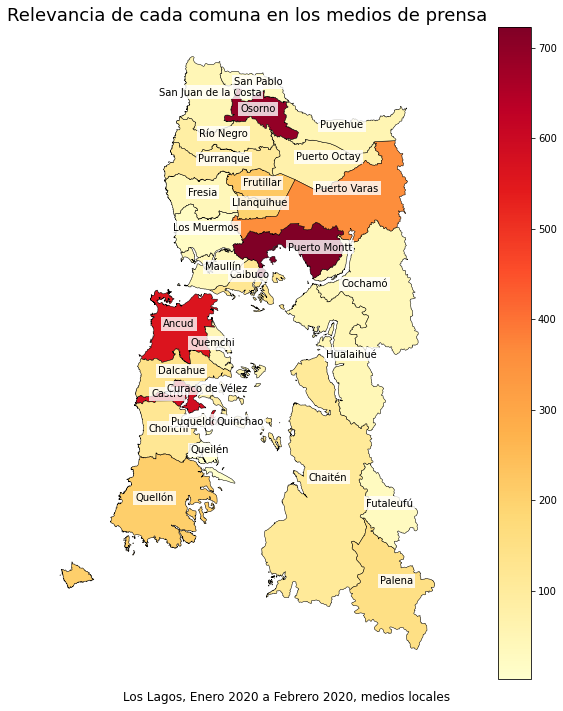

In [265]:
# Graficamos los datos
territory.plot(column="values", legend=True, figsize=(16, 12), cmap="YlOrRd", edgecolor="black", linewidth=0.5).set_axis_off();
# Información
plt.title("Relevancia de cada comuna en los medios de prensa", fontsize=18);

for idx, row in territory.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2020 a Febrero 2020, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Relevancia_Comunas"), bbox_inches = "tight",transparent = True)

In [266]:
relevanciaComunas = territory.sort_values(by=['values'], ascending=False)
relevanciaComunas

,Comuna,geometry,values,coords
165,Puerto Montt,"MULTIPOLYGON (((-8131805.489 -5110318.879, -81...",723.0,"(-8079675.275114849, -5088463.898049999)"
53,Osorno,"POLYGON ((-8162032.045 -4927188.771, -8161590....",694.0,"(-8140053.108083981, -4954148.655649999)"
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...",584.0,"(-8227801.498338105, -5230294.630800001)"
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...",560.0,"(-8216686.860888084, -5162692.993100001)"
313,Puerto Varas,"POLYGON ((-7998980.429 -5045815.686, -7998964....",362.0,"(-8053544.933829673, -5031236.82845)"
290,Frutillar,"POLYGON ((-8137646.086 -5009326.261, -8137630....",222.0,"(-8135714.484708065, -5025736.9432500005)"
162,Quellón,"MULTIPOLYGON (((-8331772.949 -5403679.835, -83...",206.0,"(-8240214.84870591, -5331248.85495)"
52,Llanquihue,"POLYGON ((-8161909.969 -5031493.581, -8161797....",198.0,"(-8138332.2775472775, -5045007.35475)"
315,Palena,"POLYGON ((-7983242.720 -5470911.800, -7983245....",151.0,"(-8005551.250409123, -5412032.1097)"
168,Dalcahue,"MULTIPOLYGON (((-8258700.750 -5225844.867, -82...",141.0,"(-8214317.499364937, -5207982.5217)"


**Positividad, negatividad y neutralidad según comuna**

In [267]:
# DF de pos, neg y neu
list_posibles = ['POS','NEU','NEG','porcent_POS','porcent_NEU','porcent_NEG'] #Lo dejo como lista para no escibirlo después
df_POS_NEG_NEU = pd.DataFrame(columns=list_posibles, index=comunas)
df_POS_NEG_NEU =  df_POS_NEG_NEU.fillna(0)  #Lo rellenamos de 0s

In [268]:
#Funcion que en base a la cantidad de noticias pos, neg y neu, las ordena por comuna
def organizaSentimiento(sent,df_dominant_topic, comunas): #sent = POS, NEG O NEU
    sentimiento = sqldf(f"SELECT * FROM df_dominant_topic WHERE title_label='{sent}'")

    petitionSQLDF  = 'SELECT '
    for comuna in comunas :
        # Si encuentra un espacio entonces añade corchetes para la petición en mysql
        if comuna.find(' ') > 0 :
            petitionSQLDF = petitionSQLDF+('sum(['+comuna+']), ')
        else :
            petitionSQLDF = petitionSQLDF+('sum('+comuna+'), ')

    petitionSQLDF = petitionSQLDF[:-2] # eliminamos la última coma
    petitionSQLDF = petitionSQLDF+' FROM sentimiento'
    petitionSQLDF

    result = sqldf(petitionSQLDF)


    values = result.values[0]
    return values

In [269]:
df_POS_NEG_NEU['POS'] = organizaSentimiento('POS',df_dominant_topic, comunas)
df_POS_NEG_NEU['NEU'] = organizaSentimiento('NEU',df_dominant_topic, comunas)
df_POS_NEG_NEU['NEG'] = organizaSentimiento('NEG',df_dominant_topic, comunas)
df_POS_NEG_NEU.head(3)

,POS,NEU,NEG,porcent_POS,porcent_NEU,porcent_NEG
Ancud,45.0,340.0,175.0,0,0,0
Calbuco,21.0,64.0,37.0,0,0,0
Castro,104.0,367.0,113.0,0,0,0


In [270]:
for comuna in comunas:
    POSi = df_POS_NEG_NEU.loc[comuna]['POS']
    NEUt = df_POS_NEG_NEU.loc[comuna]['NEU']
    NEGa = df_POS_NEG_NEU.loc[comuna]['NEG']
    df_POS_NEG_NEU.loc[comuna] = [POSi, NEUt, NEGa, POSi/(POSi+NEUt+NEGa),NEUt/(POSi+NEUt+NEGa),NEGa/(POSi+NEUt+NEGa)]
df_POS_NEG_NEU.head(3)

,POS,NEU,NEG,porcent_POS,porcent_NEU,porcent_NEG
Ancud,45.0,340.0,175.0,0.080357,0.607143,0.312500
Calbuco,21.0,64.0,37.0,0.172131,0.524590,0.303279
Castro,104.0,367.0,113.0,0.178082,0.628425,0.193493


In [271]:
#Creamos el df de territorio para el grafico
territorySent = territory.drop(['values'],axis=1)
territorySent.head(1)

,Comuna,geometry,coords
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)"


In [272]:
#Agregamos los datos de sentimiento
territorySent['POS'] = list(df_POS_NEG_NEU['POS'].values)
territorySent['NEU'] = list(df_POS_NEG_NEU['NEU'].values)
territorySent['NEG'] = list(df_POS_NEG_NEU['NEG'].values)
territorySent['porcent_POS'] = list(df_POS_NEG_NEU['porcent_POS'].values)
territorySent['porcent_NEU'] = list(df_POS_NEG_NEU['porcent_NEU'].values)
territorySent['porcent_NEG'] = list(df_POS_NEG_NEU['porcent_NEG'].values)
territorySent.head(3)

,Comuna,geometry,coords,POS,NEU,NEG,porcent_POS,porcent_NEU,porcent_NEG
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",45.0,340.0,175.0,0.080357,0.607143,0.312500
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",21.0,64.0,37.0,0.172131,0.524590,0.303279
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",104.0,367.0,113.0,0.178082,0.628425,0.193493


In [273]:
valMax = max(territorySent['POS'])
valMax

126.0

**Gráfico mapa positivo**


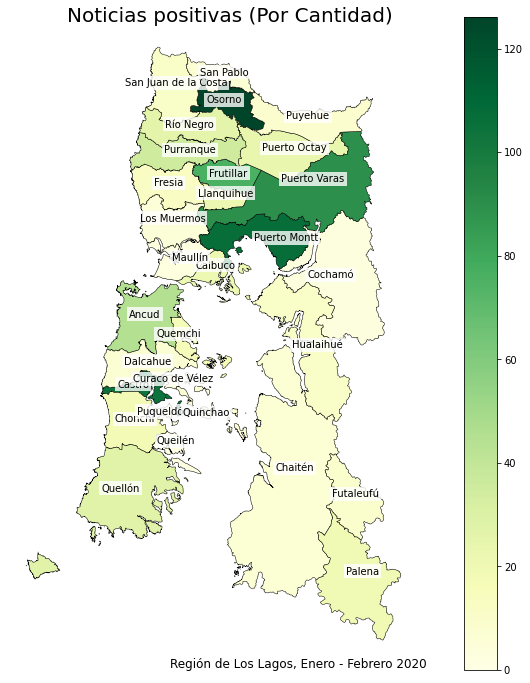

In [274]:
# Graficamos por noticias Positivas (Cantidad)
territorySent.plot(column="POS", cmap='YlGn', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=valMax).set_axis_off();


plt.text(0.58, 0.875, 'Noticias positivas (Por Cantidad)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Región de Los Lagos, Enero - Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_positivas_Cantidad"), bbox_inches = "tight",transparent = True)

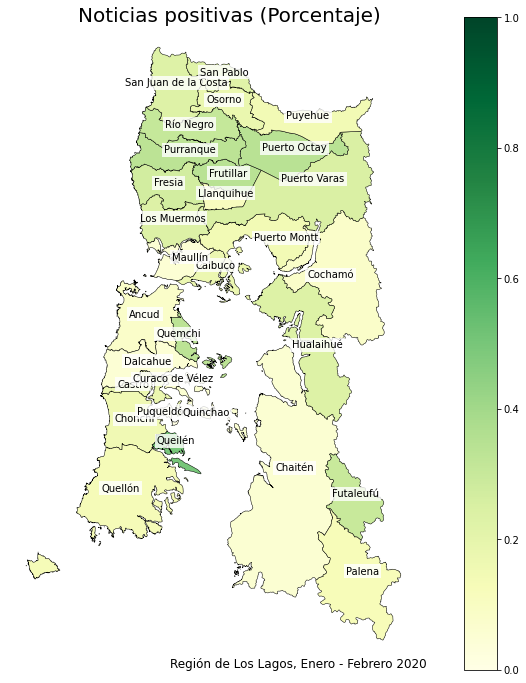

In [275]:
# Graficamos por noticias Positivas (Porcentaje)
territorySent.plot(column="porcent_POS", cmap='YlGn', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();

plt.text(0.58, 0.875, 'Noticias positivas (Porcentaje)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Región de Los Lagos, Enero - Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_positivas_Porcentaje"), bbox_inches = "tight",transparent = True)

**Gráfico mapa neutro**


In [276]:
valMax = max(territorySent['NEG'])
valMax

222.0

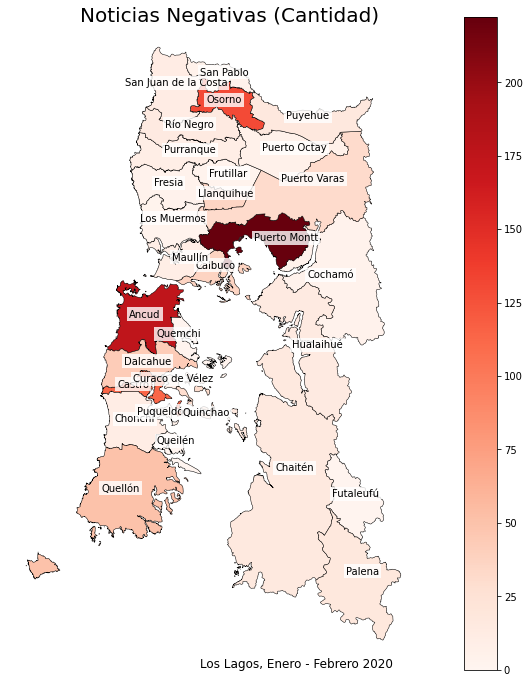

In [277]:
# Graficamos por noticias Negativas (Cantidad)
territorySent.plot(column="NEG", cmap='Reds', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=valMax).set_axis_off();

plt.text(0.58, 0.875, 'Noticias Negativas (Cantidad)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero - Febrero 2020 ", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_Negativas_Cantidad"), bbox_inches = "tight",transparent = True)

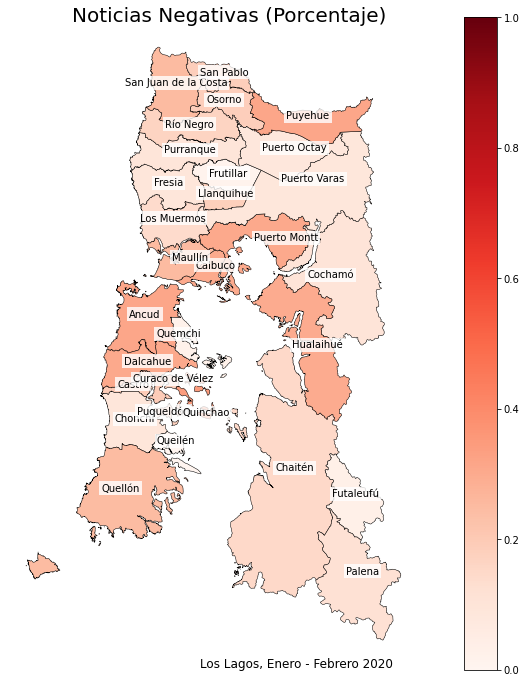

In [278]:
# Graficamos por noticias Negativas (Porcentaje)
territorySent.plot(column="porcent_NEG", cmap='Reds', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();

plt.text(0.58, 0.875, 'Noticias Negativas (Porcentaje)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero - Febrero 2020 ", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_Negativas_Porcentaje"), bbox_inches = "tight",transparent = True)

In [279]:
valMax = max(territorySent['NEU'])
valMax

438.0

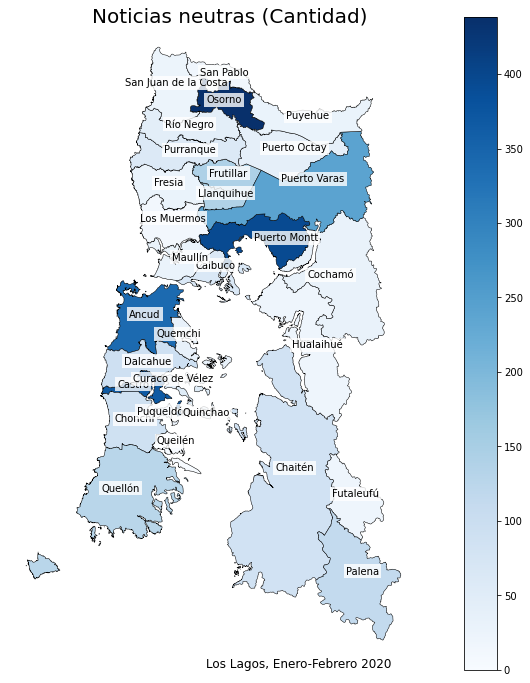

In [280]:
# Noticias neutras (Cantidad)
territorySent.plot(column="NEU", cmap='Blues', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=valMax).set_axis_off();


plt.text(0.58, 0.875, 'Noticias neutras (Cantidad)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero-Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_neutras_Cantidad"), bbox_inches = "tight",transparent = True)

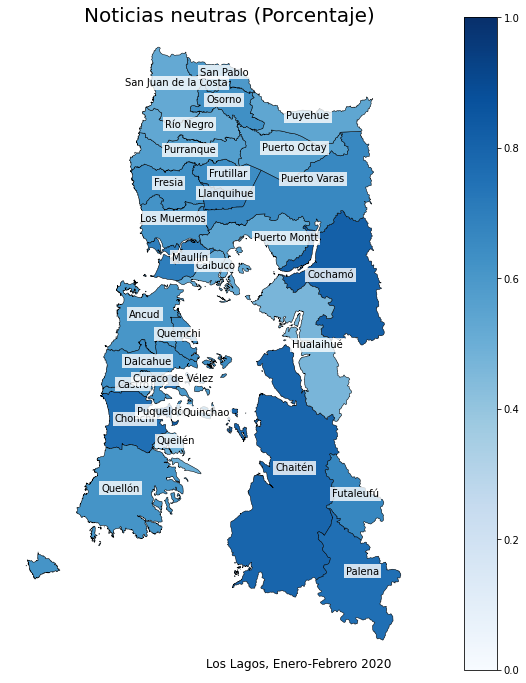

In [281]:
# Noticias neutras (porcentaje)
territorySent.plot(column="porcent_NEU", cmap='Blues', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=1).set_axis_off();


plt.text(0.58, 0.875, 'Noticias neutras (Porcentaje)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territorySent.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero-Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_neutras_Porcentaje"), bbox_inches = "tight",transparent = True)

**Ultimo Robos**

Teniendo en cuenta que el topico 1 habla de personas, reformas y proyectos, está más enfocado a la comunidad.
Aquí la idea es encontrar las comunas donde se hable más de esto, osea encontrar las comunas donde más se habla de cosas sociales

In [282]:
#Seleccionamos todas las noticias que tienen que ver con el tópico 1, también veremos cuantas son positivas, negativas y neutras
Consulta = sqldf("SELECT * FROM df_dominant_topic WHERE Dominant_Topic=1")
Consulta.head(1)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Unnamed: 0,id_news,country,media_outlet,url,...,Puyehue,Queilén,Quellón,Quemchi,Quinchao,Río Negro,San Juan de la Costa,San Pablo,title_label,title_score
0,29,1,0.3875,"equipo, enfermedad, virus, años, VerdadesOcult...",Cada pala de tierra que se mueve es un enorme ...,29,21892412.0,chile,radiosago,https://www.radiosago.cl/mas-de-1-800-procedim...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,POS,0.992522


In [285]:
# DF de pos, neg y neu
list_posibles = ['POS','NEU','NEG','TOTAL'] #Lo dejo como lista para no escibirlo después
df_topic1 = pd.DataFrame(columns=list_posibles, index=comunas)
df_topic1 =  df_topic1.fillna(0)  #Lo rellenamos de 0s
df_topic1

,POS,NEU,NEG,TOTAL
Ancud,0,0,0,0
Calbuco,0,0,0,0
Castro,0,0,0,0
Chaitén,0,0,0,0
Chonchi,0,0,0,0
Cochamó,0,0,0,0
Curaco de Vélez,0,0,0,0
Dalcahue,0,0,0,0
Fresia,0,0,0,0
Frutillar,0,0,0,0


In [286]:
df_topic1['POS'] = organizaSentimiento('POS',Consulta, comunas)
df_topic1['NEU'] = organizaSentimiento('NEU',Consulta, comunas)
df_topic1['NEG'] = organizaSentimiento('NEG',Consulta, comunas)
df_topic1['TOTAL'] = (organizaSentimiento('POS',Consulta, comunas)+organizaSentimiento('NEU',Consulta, comunas)+organizaSentimiento('NEG',Consulta, comunas))
df_topic1

,POS,NEU,NEG,TOTAL
Ancud,10.0,34.0,14.0,58.0
Calbuco,7.0,3.0,6.0,16.0
Castro,31.0,72.0,11.0,114.0
Chaitén,0.0,2.0,0.0,2.0
Chonchi,11.0,10.0,2.0,23.0
Cochamó,0.0,0.0,0.0,0.0
Curaco de Vélez,0.0,3.0,0.0,3.0
Dalcahue,5.0,4.0,2.0,11.0
Fresia,4.0,5.0,0.0,9.0
Frutillar,8.0,14.0,3.0,25.0


In [289]:
#Creamos el df de territorio para el grafico
territory_1 = territory.drop(['values'],axis=1)
territory_1.head(1)

,Comuna,geometry,coords
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)"


In [290]:
#Agregamos los datos de sentimiento
territory_1['POS'] = list(df_topic1['POS'].values)
territory_1['NEU'] = list(df_topic1['NEU'].values)
territory_1['NEG'] = list(df_topic1['NEG'].values)
territory_1['TOTAL'] = list(df_topic1['TOTAL'].values)

territory_1.head(3)

,Comuna,geometry,coords,POS,NEU,NEG,TOTAL
161,Ancud,"MULTIPOLYGON (((-8254683.395 -5190030.921, -82...","(-8216686.860888084, -5162692.993100001)",10.0,34.0,14.0,58.0
254,Calbuco,"MULTIPOLYGON (((-8112967.653 -5147692.027, -81...","(-8148106.117221469, -5115110.540750001)",7.0,3.0,6.0,16.0
167,Castro,"MULTIPOLYGON (((-8171095.068 -5254002.891, -81...","(-8227801.498338105, -5230294.630800001)",31.0,72.0,11.0,114.0


**Relevancia del topico 1 por comunas**

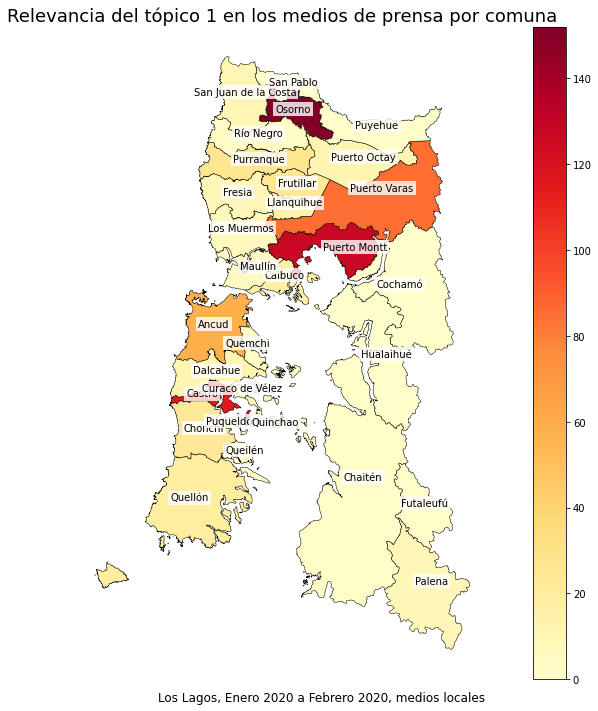

In [292]:
# Graficamos los datos
territory_1.plot(column="TOTAL", legend=True, figsize=(16, 12), cmap="YlOrRd", edgecolor="black", linewidth=0.5).set_axis_off();
# Información
plt.title("Relevancia del tópico 1 en los medios de prensa por comuna", fontsize=18);

for idx, row in territory.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(0.6, 0.1, "Los Lagos, Enero 2020 a Febrero 2020, medios locales", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Relevancia_topico_1_TOTAL"), bbox_inches = "tight",transparent = True)

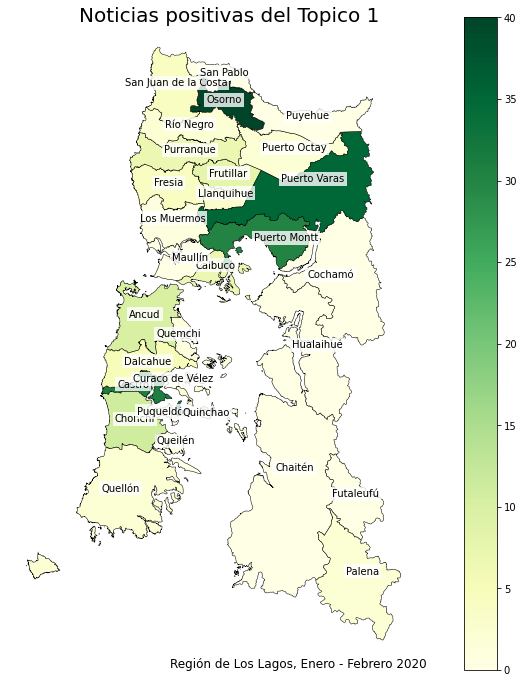

In [293]:
# Graficamos por noticias Positivas (Topico 1)
territory_1.plot(column="POS", cmap='YlGn', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=max(territory_1['POS'])).set_axis_off();


plt.text(0.58, 0.875, 'Noticias positivas del Topico 1', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_1.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Región de Los Lagos, Enero - Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_positivas_Topico_1"), bbox_inches = "tight",transparent = True)

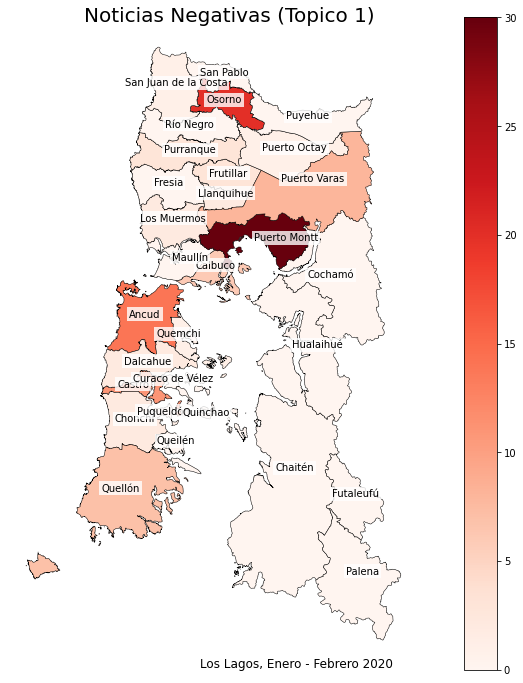

In [295]:
# Graficamos por noticias Negativas (Topico 1)
territory_1.plot(column="NEG", cmap='Reds', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=max(territory_1['NEG'])).set_axis_off();

plt.text(0.58, 0.875, 'Noticias Negativas (Topico 1)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_1.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero - Febrero 2020 ", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_Negativas_Topico_1"), bbox_inches = "tight",transparent = True)

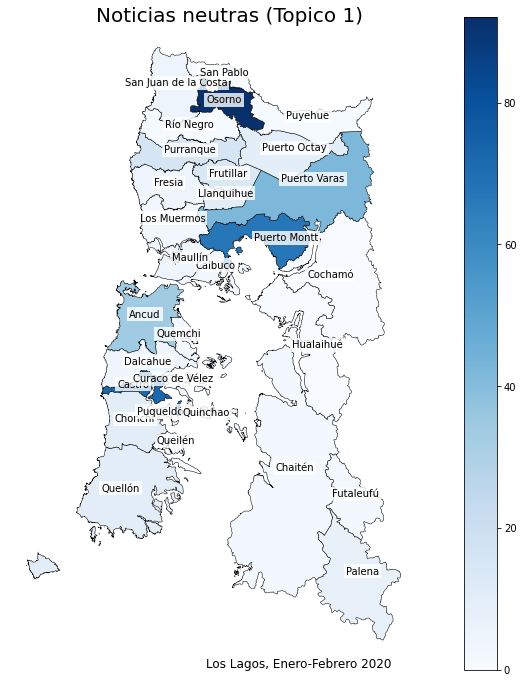

In [296]:
# Noticias neutras (Topico 1)
territory_1.plot(column="NEU", cmap='Blues', legend=True, figsize=(16, 12), edgecolor="black", linewidth=0.5,missing_kwds={
        'color': 'lightgrey',
        'hatch': '///',
        'edgecolor': 'black',
        'label': 'Missing values',
}, vmin=0, vmax=max(territory_1['NEU'])).set_axis_off();


plt.text(0.58, 0.875, 'Noticias neutras (Topico 1)', fontsize=20, ha='center', transform=plt.gcf().transFigure);

for idx, row in territory_1.iterrows():
    plt.text(row.coords[0], row.coords[1], s=row['Comuna'], horizontalalignment='center', bbox={'facecolor': 'white', 'alpha':0.8, 'pad': 2, 'edgecolor':'none'})

plt.text(.64, 0.128, "Los Lagos, Enero-Febrero 2020", fontsize=12, ha='center', transform=plt.gcf().transFigure);
plt.savefig('./data/images//{}.png'.format("Noticias_neutras_Topico_1"), bbox_inches = "tight",transparent = True)

### ***Parte 6: Reportes***